# Correlation Budget Teacher


In [1]:
from school_analysis.preprocessing.helpers.students_teachers import combine_school_type, map_gender
from school_analysis.preprocessing.load import Loader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tueplots.constants.color import rgb
import school_analysis as sa
from school_analysis.plotting.general import GeneralPlots
from school_analysis.preprocessing import SCHOOL_TYPE_MAPPING

CONTRACT_TYPE = [
    "Vollzeitbeschäftigte Lehrkräfte",
    # "Teilzeitbeschäftigte Lehrkräfte",
    # "Stundenweise beschäftigte Lehrkräfte"
]

loader = Loader()

# Budgets
budget = loader.load("budgets-corrected")

# Teachers
teachers = loader.load("teachers-per-schooltype")
teachers = map_gender(teachers)
teachers = teachers[teachers["Contract Type"].isin(CONTRACT_TYPE)]
teachers = teachers[teachers["Gender"] == "all"]
teachers = teachers.groupby(["Year", "Federal State"])[
    "Number of Teachers"].sum().reset_index()
teachers_states = teachers[teachers["Federal State"] != "Deutschland"]
teachers = teachers[teachers["Federal State"] == "Deutschland"]

## By federal state


In [2]:
bt_state = pd.merge(budget, teachers_states, on=[
                    "Year", "Federal State"]).dropna()

# Correlation
print("Correlation between budget and teachers: ", np.corrcoef(
    bt_state["Reference Budget"], bt_state["Number of Teachers"])[0, 1])
bt_state

Correlation between budget and teachers:  -0.22467127410755092


,Federal State,Year,Budget,Index,Year Relative,Reference Budget,Number of Teachers
0,Baden-Württemberg,2010,6100,0.880,2020,6931.818182,102106.0
1,Bayern,2010,6400,0.876,2020,7305.936073,117780.0
2,Brandenburg,2010,6200,0.887,2020,6989.853439,21490.0
3,Bremen,2010,6100,0.875,2020,6971.428571,6124.0
5,Hessen,2010,6500,0.896,2020,7254.464286,63904.0
...,...,...,...,...,...,...,...
160,Saarland,2020,8300,1.000,2020,8300.000000,11648.0
161,Sachsen,2020,8400,1.000,2020,8400.000000,37600.0
162,Sachsen-Anhalt,2020,8300,1.000,2020,8300.000000,24732.0
163,Schleswig-Holstein,2020,8200,1.000,2020,8200.000000,27262.0


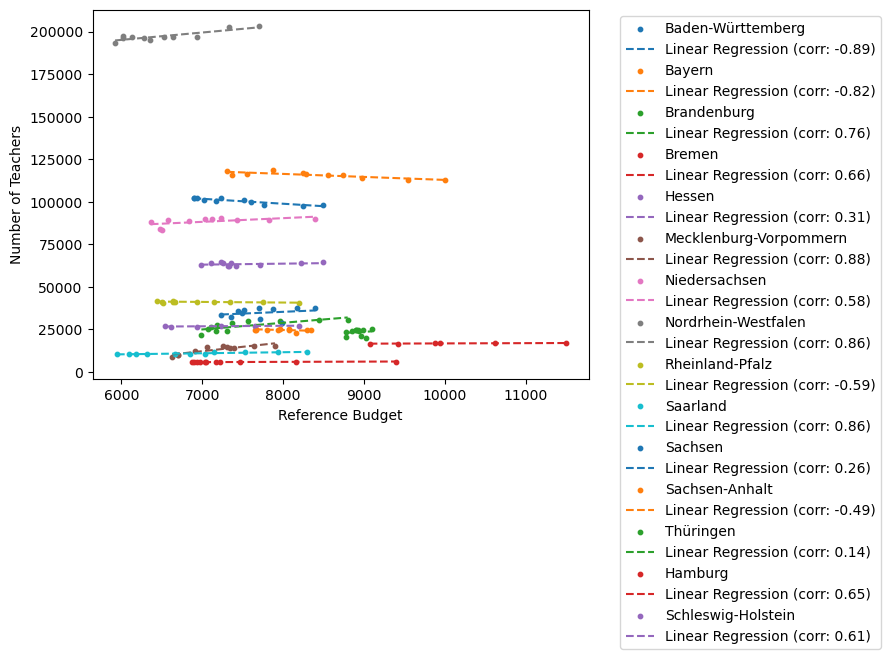

In [3]:
# Plot
fig, ax = plt.subplots(1, 1)
x_col = "Reference Budget"
y_col = "Number of Teachers"

for s in bt_state["Federal State"].unique():
    idx = bt_state["Federal State"] == s
    ax.scatter(bt_state.loc[idx, x_col],
               bt_state.loc[idx, y_col], label=s, s=10)
    corr = np.corrcoef(bt_state.loc[idx, x_col],
                       bt_state.loc[idx, y_col])[0][1]
    X = np.vstack([np.ones(len(bt_state.loc[idx, x_col])),
                  bt_state.loc[idx, x_col]]).T
    y = bt_state.loc[idx, y_col]
    w, res, _, _ = np.linalg.lstsq(X, y, rcond=None)
    minimum = bt_state.loc[idx, x_col].min()
    maximum = bt_state.loc[idx, x_col].max()
    xp = np.linspace(minimum, maximum, int(abs(maximum - minimum) * 100))
    ax.plot(xp, w[0] + w[1] * xp, "--",
            label="Linear Regression (corr: {:.2f})".format(corr))

ax.set_xlabel("Reference Budget")
ax.set_ylabel("Number of Teachers")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [4]:
def correlation(data_frame: pd.DataFrame, col1: str, col2: str) -> float:
    return np.corrcoef(data_frame[col1], data_frame[col2])[0][1]

In [5]:
from tabulate import tabulate

result = []
for state in bt_state["Federal State"].unique():
    bt_state_group = bt_state[bt_state["Federal State"] == state]
    corr = {}
    # Get corr
    corr["Budget"] = correlation(
        bt_state_group, "Number of Teachers", "Reference Budget")

    # Meta
    corr["state"] = state
    corr["Type"] = "New" if state in sa.NEW_OLD_STATES_MAPPING["New Federal States"] else "Old"
    result.append(corr)

result = pd.DataFrame(result).sort_values(
    by=["Type", "Budget"], ascending=False)
result

,Budget,state,Type
7,0.864771,Nordrhein-Westfalen,Old
9,0.858333,Saarland,Old
3,0.659135,Bremen,Old
13,0.653070,Hamburg,Old
14,0.609795,Schleswig-Holstein,Old
6,0.582419,Niedersachsen,Old
4,0.311959,Hessen,Old
8,-0.592808,Rheinland-Pfalz,Old
1,-0.819000,Bayern,Old
0,-0.891082,Baden-Württemberg,Old


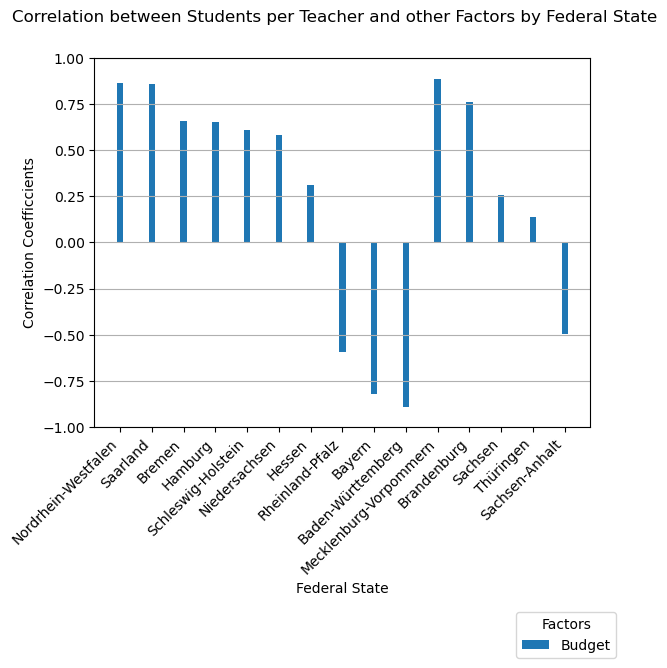

In [6]:
fig, ax = plt.subplots(1,  1)

# Define the number of bars and their positions
num_bars = 3
bar_width = 0.2
positions = np.arange(len(result["state"]))

# Create the bars
# ax.bar(positions - bar_width,
#        result["Avg. Grade"], width=bar_width, label="Avg. Grade")
ax.bar(positions, result["Budget"], width=bar_width, label="Budget")

# Set the x-ticks to be the middle of the bars
ax.set_xticks(positions)
ax.set_ylabel("Correlation Coefficcients")
ax.set_xlabel("Federal State")
ax.set_xticklabels(result["state"], rotation=45, ha='right')
ax.legend(title="Factors", bbox_to_anchor=(
    0.85, -0.5), loc='upper left', borderaxespad=0.)
ax.grid(axis="y")
ax.set_yticks(np.arange(-1, 1.1, 0.25))

fig.suptitle(
    "Correlation between Students per Teacher and other Factors by Federal State")
plt.show()